In [1]:
# Importing required libraries
import json
import tensorflow as tf
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Get the dataset
srcsm_json = requests.get('https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json')

# Inspecting the data
print(srcsm_json.text[0:450])


# Separate the json into sentences and labels
sentences = []
labels = []

for item in srcsm_json.json():
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])
    
# Dataset head print
print(pd.DataFrame({'senetence' : sentences[0:10], 'label':labels[0:10]}))

[
{"article_link": "https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5", "headline": "former versace store clerk sues over secret 'black code' for minority shoppers", "is_sarcastic": 0},
{"article_link": "https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365", "headline": "the 'roseanne' revival catches up to our thorny political mood, for better and worse", "is_sarcastic": 0},
                                           senetence  label
0  former versace store clerk sues over secret 'b...      0
1  the 'roseanne' revival catches up to our thorn...      0
2  mom starting to fear son's web series closest ...      1
3  boehner just wants wife to listen, not come up...      1
4  j.k. rowling wishes snape happy birthday in th...      0
5                        advancing the world's women      0
6     the fascinating case for eating lab-grown meat      0
7  this ceo will send your kids to school, if you...      0
8  top snak

In [3]:
# Splitting the dataset into Train and Test
training_size = round(len(sentences) * .75)

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]


# Setting tokenizer properties
vocab_size = 10000
oov_tok = "<oov>"

# Fit the tokenizer on Training data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

# Setting the padding properties
max_length = 100
trunc_type='post'
padding_type='post'


# Creating padded sequences from train and test data
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [4]:
# Setting the model
embedding_dim = 16


model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Converting the lists to numpy arrays for Tensorflow 2.x
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)


# Training the model
num_epochs = 30

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Train on 20032 samples, validate on 6677 samples
Epoch 1/30
20032/20032 - 3s - loss: 0.6737 - accuracy: 0.5679 - val_loss: 0.6128 - val_accuracy: 0.6689
Epoch 2/30
20032/20032 - 3s - loss: 0.4411 - accuracy: 0.8213 - val_loss: 0.3826 - val_accuracy: 0.8417
Epoch 3/30
20032/20032 - 3s - loss: 0.3104 - accuracy: 0.8772 - val_loss: 0.3801 - val_accuracy: 0.8258
Epoch 4/30
20032/20032 - 3s - loss: 0.2601 - accuracy: 0.8979 - val_loss: 0.3450 - val_accuracy: 0.8540
Epoch 5/30
20032/20032 - 3s - loss: 0.2242 - accuracy: 0.9132 - val_loss: 0.3465 - val_accuracy: 0.8534
Epoch 6/30
20032/20032 - 3s - loss: 0.1977 - accuracy: 0.9240 - val_loss: 0.3532 - val_accuracy: 0.8528
Epoch 7/30
20032/20032 - 3s - loss: 0.1731 - accuracy: 0.9352 - val_loss: 0.3644 - val_accuracy: 0.8571
Epoch 8/30
20032/20032 - 3s - loss: 0.1554 - accuracy: 0.9423 - val_loss: 0.3788 - val_accuracy: 0.8550
Epoch 9/30
20032/20032 - 3s - loss: 0.1405 - accuracy: 0.9489 - val_loss: 0.3963 - val_accuracy: 0.8543
Epoch 10/30
200

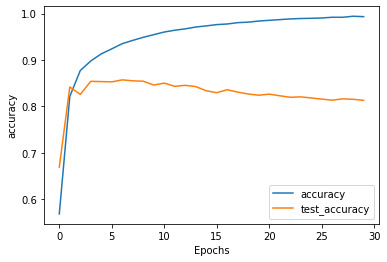

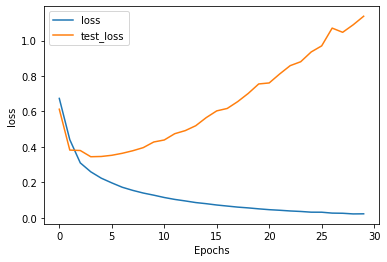

In [6]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'test_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

plt.show()